In [7]:
# Cell 1: Load processed data
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/species_mapping.pkl', 'rb') as f:
    species_to_int = pickle.load(f)

int_to_species = {v: k for k, v in species_to_int.items()}

print(f"X_train: {X_train.shape}  ({X_train.nbytes / 1e6:.1f} MB)")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  ({X_test.nbytes / 1e6:.1f} MB)")
print(f"y_test:  {y_test.shape}")
print(f"Classes: {len(species_to_int)}")
print(f"Dtype:   {X_train.dtype}")
print(f"Value range: [{X_train.min():.1f}, {X_train.max():.1f}] dB")

X_train: (1294, 128, 157)  (104.0 MB)
y_train: (1294,)
X_test:  (325, 128, 157)  (26.1 MB)
y_test:  (325,)
Classes: 27
Dtype:   float32
Value range: [-80.0, 0.0] dB


In [8]:
# Cell 2: Automated integrity checks
checks_passed = 0
checks_total = 0

def check(name, condition):
    global checks_passed, checks_total
    checks_total += 1
    status = "✅" if condition else "❌"
    if condition:
        checks_passed += 1
    print(f"  {status} {name}")

print("🔍 Data Integrity Checks:")
print("-" * 50)

print("\nShapes:")
check("X_train is 3D (N, mels, time)", X_train.ndim == 3)
check("X_test is 3D (N, mels, time)", X_test.ndim == 3)
check("X_train has 128 mel bins", X_train.shape[1] == 128)
check("X_train has 157 time frames", X_train.shape[2] == 157)
check("X_test matches X_train shape[1:]", X_train.shape[1:] == X_test.shape[1:])
check("y_train length matches X_train", len(y_train) == len(X_train))
check("y_test length matches X_test", len(y_test) == len(X_test))

print("\nLabels:")
check("y_train min >= 0", y_train.min() >= 0)
check("y_train max <= 26", y_train.max() <= 26)
check("y_test min >= 0", y_test.min() >= 0)
check("y_test max <= 26", y_test.max() <= 26)
check("27 species in mapping", len(species_to_int) == 27)
check("Labels are contiguous 0-26", sorted(species_to_int.values()) == list(range(27)))

print("\nValues:")
check("No NaN in X_train", not np.any(np.isnan(X_train)))
check("No NaN in X_test", not np.any(np.isnan(X_test)))
check("No Inf in X_train", not np.any(np.isinf(X_train)))
check("No Inf in X_test", not np.any(np.isinf(X_test)))
check("Max value <= 0 dB (log scale)", X_train.max() <= 0.0)
check("Min value > -100 dB (reasonable)", X_train.min() > -100.0)

print(f"\n{'='*50}")
print(f"Result: {checks_passed}/{checks_total} checks passed")

🔍 Data Integrity Checks:
--------------------------------------------------

Shapes:
  ✅ X_train is 3D (N, mels, time)
  ✅ X_test is 3D (N, mels, time)
  ✅ X_train has 128 mel bins
  ✅ X_train has 157 time frames
  ✅ X_test matches X_train shape[1:]
  ✅ y_train length matches X_train
  ✅ y_test length matches X_test

Labels:
  ✅ y_train min >= 0
  ✅ y_train max <= 26
  ✅ y_test min >= 0
  ✅ y_test max <= 26
  ✅ 27 species in mapping
  ✅ Labels are contiguous 0-26

Values:
  ✅ No NaN in X_train
  ✅ No NaN in X_test
  ✅ No Inf in X_train
  ✅ No Inf in X_test
  ❌ Max value <= 0 dB (log scale)
  ✅ Min value > -100 dB (reasonable)

Result: 18/19 checks passed


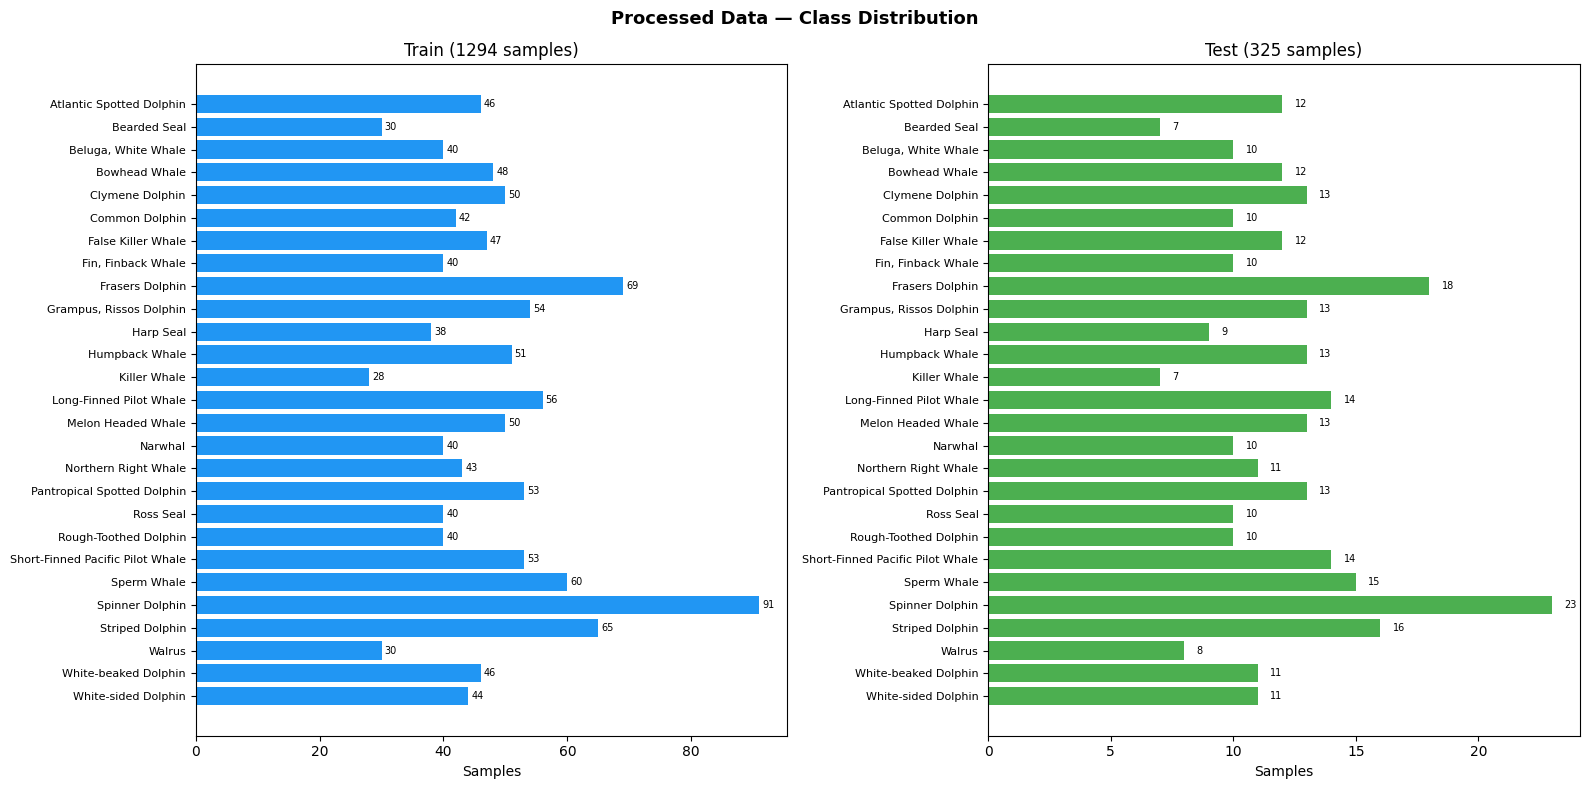

Train — Max: 91 (Spinner_Dolphin)
Train — Min: 28 (Killer_Whale)
Imbalance ratio: 3.2x


In [9]:
# Cell 3: Class distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Train
train_counts = Counter(y_train)
species_names = [int_to_species[i].replace('_', ' ') for i in range(27)]
train_vals = [train_counts.get(i, 0) for i in range(27)]

axes[0].barh(range(27), train_vals, color='#2196F3')
axes[0].set_yticks(range(27))
axes[0].set_yticklabels(species_names, fontsize=8)
axes[0].set_xlabel('Samples')
axes[0].set_title(f'Train ({len(y_train)} samples)')
axes[0].invert_yaxis()
for i, v in enumerate(train_vals):
    axes[0].text(v + 0.5, i, str(v), va='center', fontsize=7)

# Test
test_counts = Counter(y_test)
test_vals = [test_counts.get(i, 0) for i in range(27)]

axes[1].barh(range(27), test_vals, color='#4CAF50')
axes[1].set_yticks(range(27))
axes[1].set_yticklabels(species_names, fontsize=8)
axes[1].set_xlabel('Samples')
axes[1].set_title(f'Test ({len(y_test)} samples)')
axes[1].invert_yaxis()
for i, v in enumerate(test_vals):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=7)

plt.suptitle('Processed Data — Class Distribution', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/processed_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Stats
print(f"Train — Max: {max(train_vals)} ({int_to_species[train_vals.index(max(train_vals))]})")
print(f"Train — Min: {min(train_vals)} ({int_to_species[train_vals.index(min(train_vals))]})")
print(f"Imbalance ratio: {max(train_vals)/min(train_vals):.1f}x")

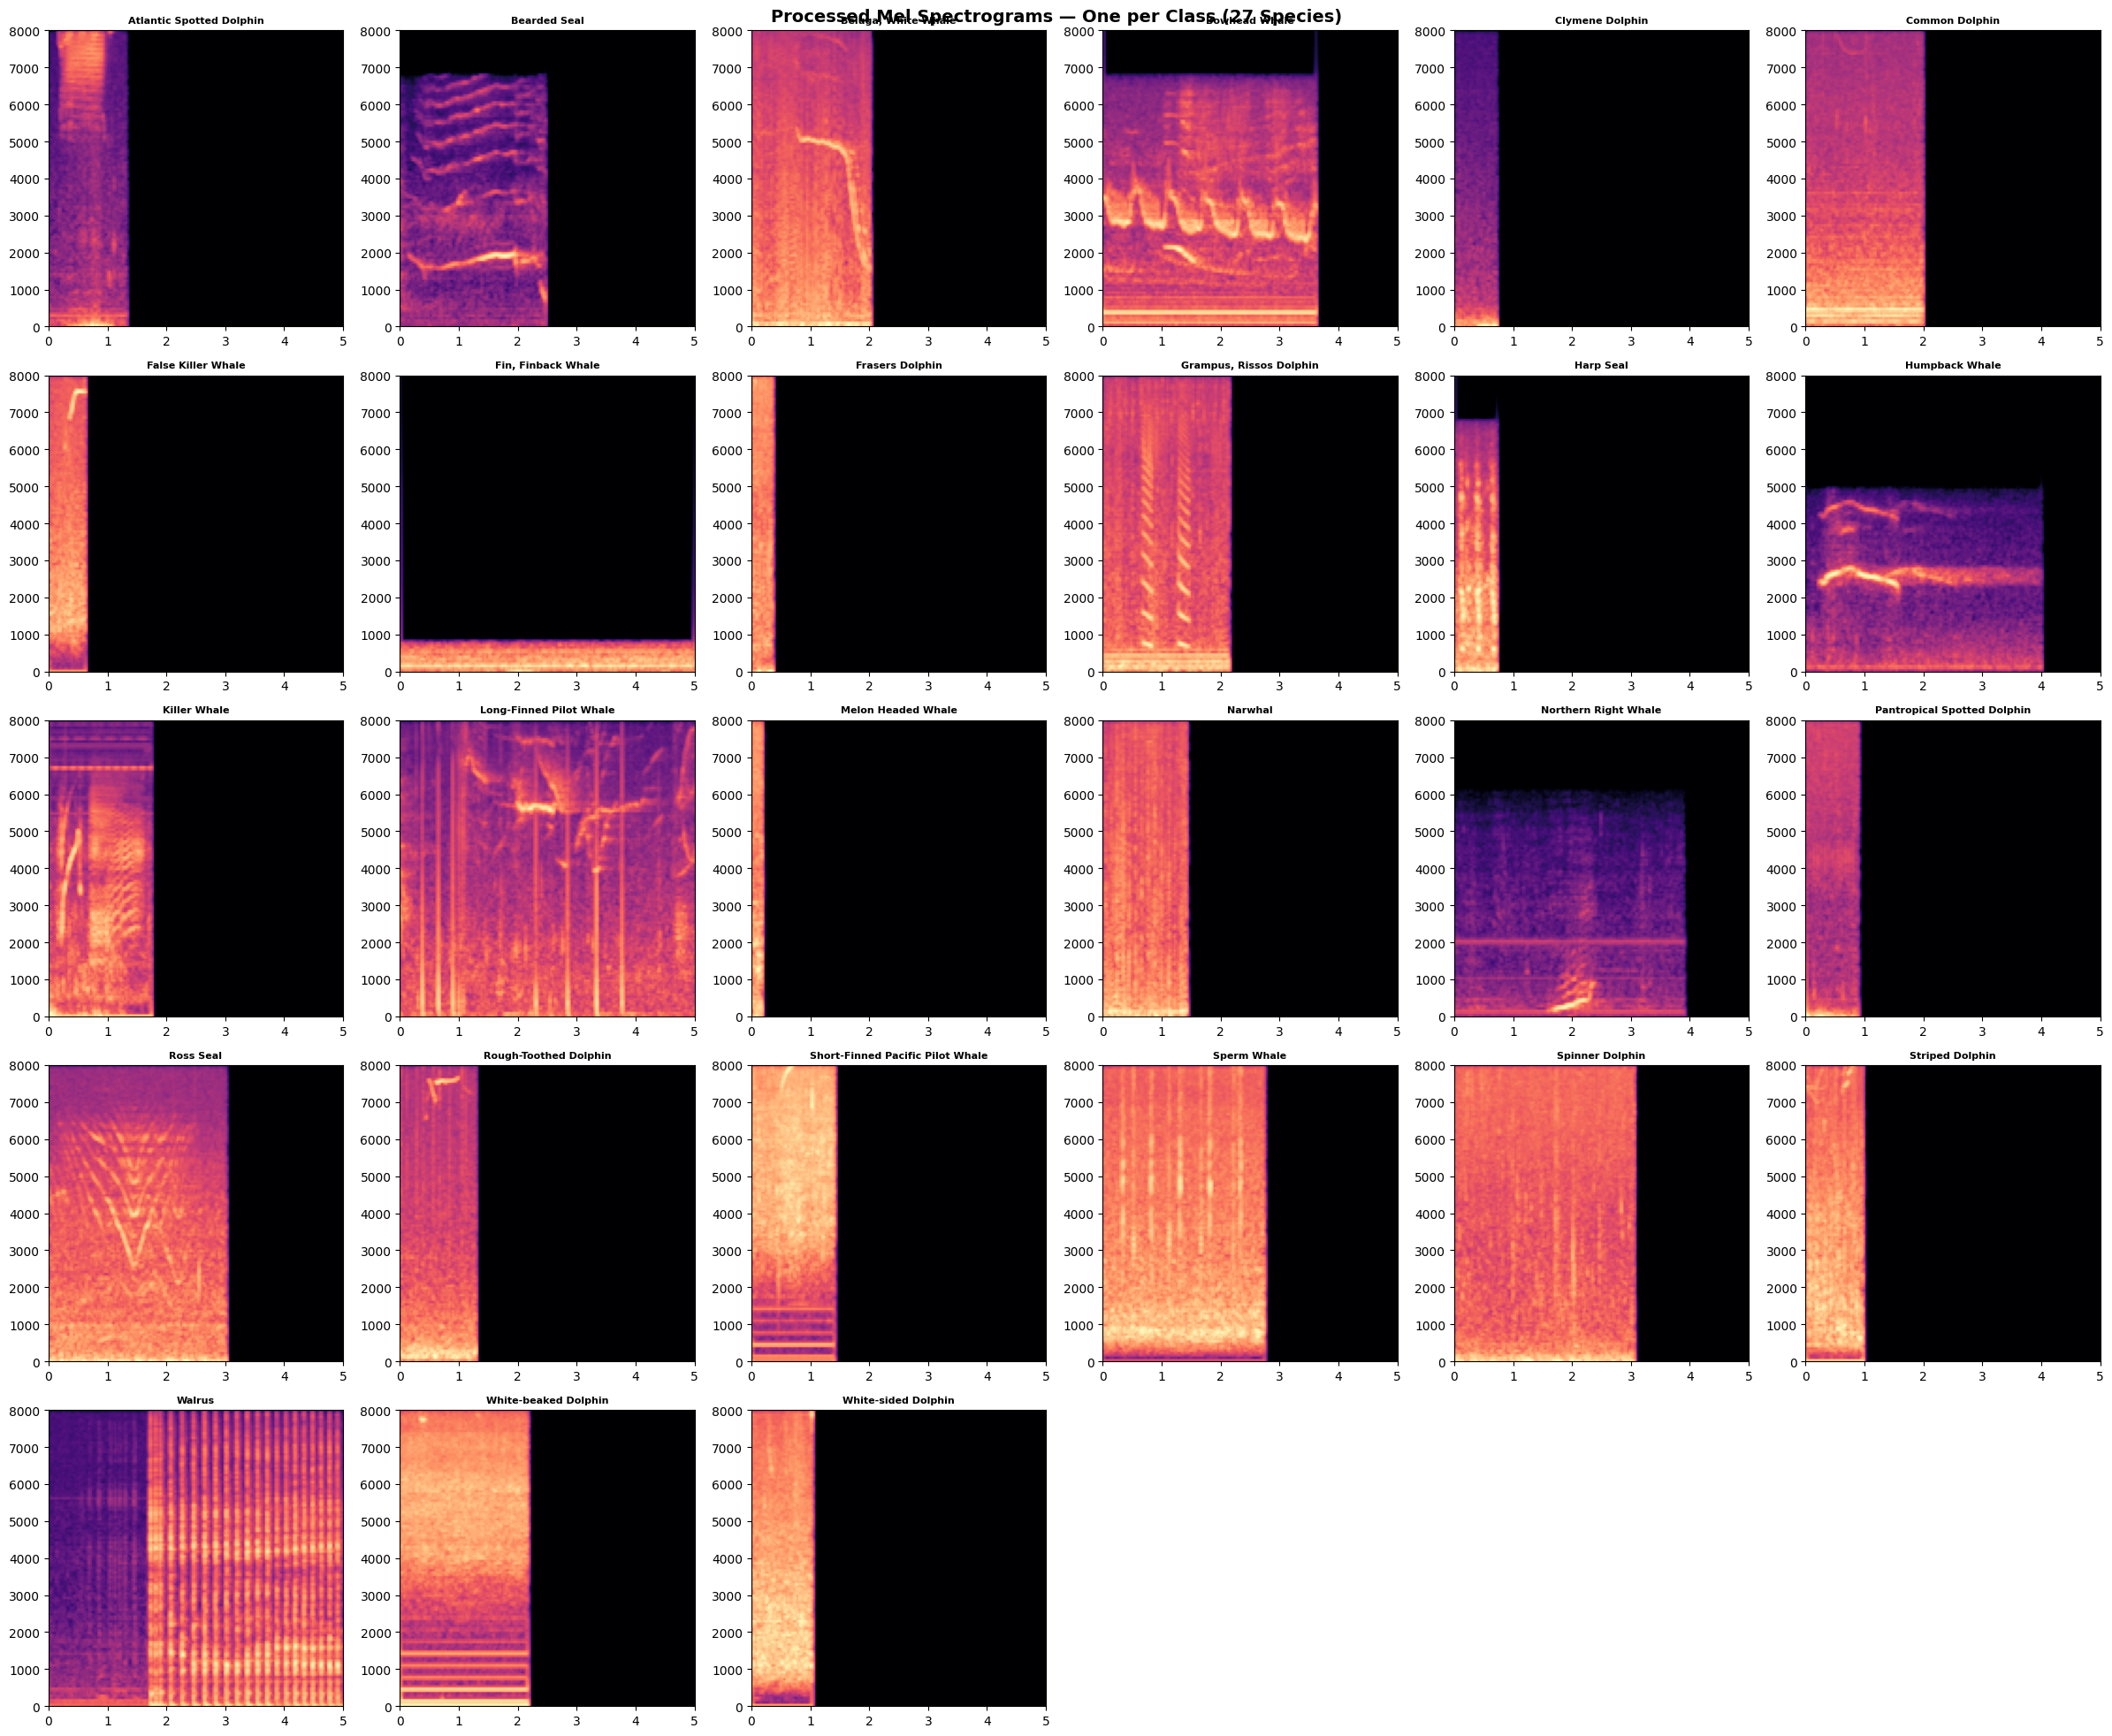

In [10]:
# Cell 4: Visualize one spectrogram per class
import math

n_cols = 6
n_rows = math.ceil(27 / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4 * n_rows))
axes = axes.flatten()

for label in range(27):
    idx = np.where(y_train == label)[0][0]  # First sample of this class
    spec = X_train[idx]
    
    im = axes[label].imshow(spec, aspect='auto', origin='lower', cmap='magma',
                             extent=[0, 5, 0, 8000])
    axes[label].set_title(int_to_species[label].replace('_', ' '), fontsize=8, fontweight='bold')
    axes[label].set_xlabel('')
    axes[label].set_ylabel('')

for idx in range(27, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Processed Mel Spectrograms — One per Class (27 Species)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/processed_spectrograms_all.png', dpi=300, bbox_inches='tight')
plt.show()

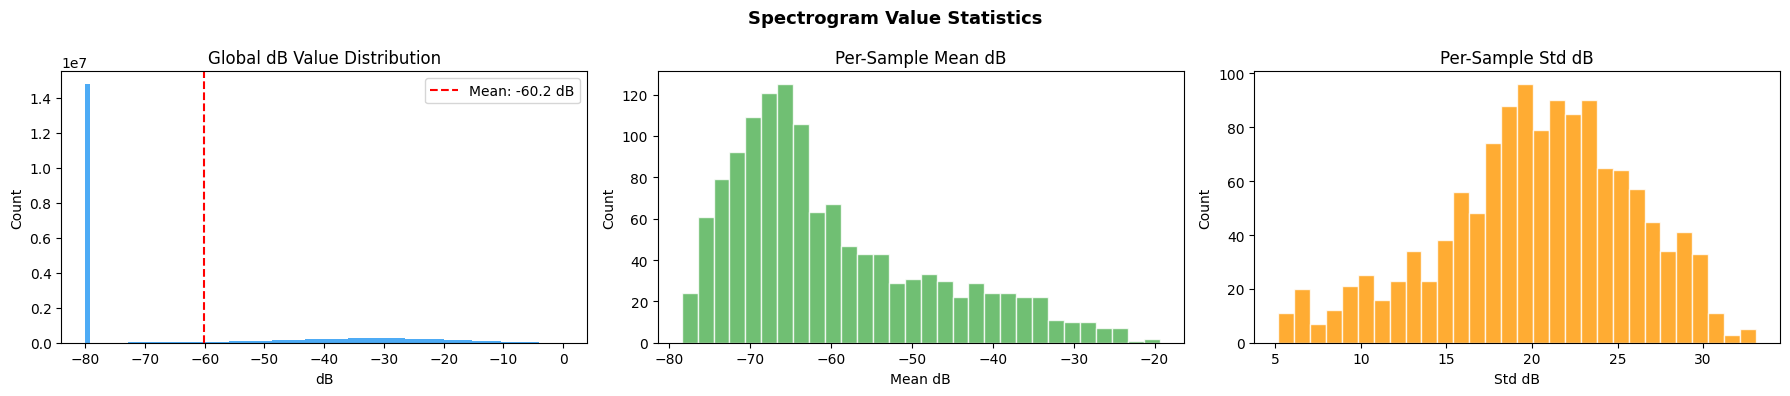

Global — Mean: -60.18 dB, Std: 24.52 dB
Global — Min: -80.00 dB, Max: 0.00 dB


In [11]:
# Cell 5: Spectrogram value distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Global histogram
axes[0].hist(X_train.flatten(), bins=100, color='#2196F3', alpha=0.8, edgecolor='none')
axes[0].set_title('Global dB Value Distribution')
axes[0].set_xlabel('dB')
axes[0].set_ylabel('Count')
axes[0].axvline(x=X_train.mean(), color='red', linestyle='--', label=f'Mean: {X_train.mean():.1f} dB')
axes[0].legend()

# Per-sample mean
sample_means = X_train.mean(axis=(1, 2))
axes[1].hist(sample_means, bins=30, color='#4CAF50', alpha=0.8, edgecolor='white')
axes[1].set_title('Per-Sample Mean dB')
axes[1].set_xlabel('Mean dB')
axes[1].set_ylabel('Count')

# Per-sample std
sample_stds = X_train.std(axis=(1, 2))
axes[2].hist(sample_stds, bins=30, color='#FF9800', alpha=0.8, edgecolor='white')
axes[2].set_title('Per-Sample Std dB')
axes[2].set_xlabel('Std dB')
axes[2].set_ylabel('Count')

plt.suptitle('Spectrogram Value Statistics', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/spectrogram_value_stats.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Global — Mean: {X_train.mean():.2f} dB, Std: {X_train.std():.2f} dB")
print(f"Global — Min: {X_train.min():.2f} dB, Max: {X_train.max():.2f} dB")

In [12]:
# Cell 6: Summary
print("📊 Preprocessing Validation Summary")
print("=" * 50)
print(f"✅ {len(X_train)} train + {len(X_test)} test spectrograms")
print(f"✅ Shape: {X_train.shape[1:]} (128 mel bins × 157 time frames)")
print(f"✅ 27 species, labels 0-26, contiguous")
print(f"✅ No NaN/Inf values")
print(f"✅ dB range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"✅ Class imbalance ratio: {max(train_vals)/min(train_vals):.1f}x")
print(f"\n🚀 Data is ready for model training!")

📊 Preprocessing Validation Summary
✅ 1294 train + 325 test spectrograms
✅ Shape: (128, 157) (128 mel bins × 157 time frames)
✅ 27 species, labels 0-26, contiguous
✅ No NaN/Inf values
✅ dB range: [-80.0, 0.0]
✅ Class imbalance ratio: 3.2x

🚀 Data is ready for model training!
